In [88]:
import scda
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'

import logging
scda.configure_log()

Populating the interactive namespace from numpy and matplotlib


# Single 'hex3' APLC design evaluation, without LS alignment tolerance

## Set the design parameters

In [96]:
pupil_params = {'N': 250, 'prim':'hex3', 'centobs':True, 'secobs':'X', 'thick':'025'}
fpm_params = {'rad': 4.}
ls_params_noaligntol = {'obscure':0, 'id':25, 'od':85, 'aligntol':None}
image_params = {'c': 10., 'ida':3.5, 'oda':8., 'bw':0.10, 'Nlam':3}

In [97]:
work_dir = "/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test" # where to write the AMPL source code
if not os.path.exists(work_dir):
    os.mkdir(work_dir)
input_dir = "/astro/opticslab1/SCDA/Apertures/InputMasks" # location of input TelAp, FPM, and LS arrays
TelAp_dir = os.path.join(input_dir, "TelAp")
FPM_dir = os.path.join(input_dir, "FPM")
LS_dir = os.path.join(input_dir, "LS")

In [98]:
design_params_noaligntol = {'Pupil': pupil_params, 'FPM': fpm_params,
                            'LS': ls_params_noaligntol, 'Image': image_params}
fileorg = {'work dir': work_dir, 'TelAp dir': TelAp_dir,
           'FPM dir': FPM_dir, 'LS dir': LS_dir}
bar_solver = {'method': 'bar'}
barhom_solver = {'method': 'barhom'}

## Initiate the coronagraph object

In [99]:
hexap_coron = scda.QuarterplaneAPLC(design=design_params_noaligntol, fileorg=fileorg, solver=barhom_solver)

## Show the file organization

In [60]:
hexap_coron.fileorg

{'FPM dir': '/astro/opticslab1/SCDA/Apertures/InputMasks/FPM',
 'FPM fname': '/astro/opticslab1/SCDA/Apertures/InputMasks/FPM/FPM_quart_occspot_M050.dat',
 'LS dir': '/astro/opticslab1/SCDA/Apertures/InputMasks/LS',
 'LS fname': '/astro/opticslab1/SCDA/Apertures/InputMasks/LS/LS_quart_ann25D90_clear_N0125.dat',
 'TelAp dir': '/astro/opticslab1/SCDA/Apertures/InputMasks/TelAp',
 'TelAp fname': '/astro/opticslab1/SCDA/Apertures/InputMasks/TelAp/TelAp_quart_hex3X025cobs1_N0125.dat',
 'ampl src dir': '/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test',
 'ampl src fname': '/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test/APLC_quart_hex3X025cobs1_N0125_FPM400M050_LSann25D90clear_Img100C_35DA080_BW10Nlam03fpres2_linbarpre1.mod',
 'eval dir': '/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test',
 'exec script dir': '/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test',
 'exec script fname': '/astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test/APLC_quart_hex3X025cobs1_N0125_FPM400M050_LSann25D90clear_Img100C_35DA080_BW10Nl

### Check the status of input files needed to run the AMPL program

In [100]:
hexap_coron.check_ampl_input_files()
print("All the input files for AMPL are in place? {0:}".format(hexap_coron.ampl_infile_status))

All the input files for AMPL are in place? True


## Write the AMPL source file

In [101]:
hexap_coron.write_ampl(override_infile_status=False, overwrite=True)

INFO:root:Wrote /astro/opticslab1/SCDA/Scripts/AMPL/LDZ_test/APLC_quart_hex3X025cobs1_N0250_FPM400M050_LSann25D85clear_Img100C_35DA080_BW10Nlam03fpres2_linbarhompre1.mod


## Create a bundled source + input file subdirectory for both designs

In [30]:
bundled_dir = "/astro/opticslab1/SCDA/Scripts/AMPL/hex3_LStol25"
#bundled_coron_list = scda.make_ampl_bundle([hexap_coron_noaligntol, hexap_coron_aligntol], bundled_dir)
#os.listdir(bundled_dir)

## Evaluate basic coronagraph metrics

In [80]:
hexap_coron.get_metrics()

Non-binary residuals, as a percentage of clear telescope aperture area: 3.50%
Band-averaged Airy throughput: 41.65%
Band-averaged FWHM PSF area / (lambda0/D)^2: 1.29


# Full-plane on-axis PSF evaluation

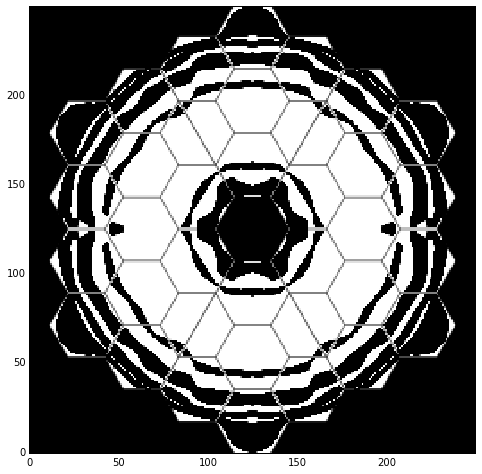

In [93]:
TelAp_qp = np.loadtxt(hexap_coron.fileorg['TelAp fname'])
TelAp = np.concatenate((np.concatenate((TelAp_qp[::-1,::-1], TelAp_qp[:,::-1]),axis=0),
                        np.concatenate((TelAp_qp[::-1,:], TelAp_qp),axis=0)), axis=1)

FPM_qp = np.loadtxt(hexap_coron.fileorg['FPM fname'])
FPM = np.concatenate((np.concatenate((FPM_qp[::-1,::-1], FPM_qp[:,::-1]),axis=0),
                      np.concatenate((FPM_qp[::-1,:], FPM_qp),axis=0)), axis=1)

LS_qp = np.loadtxt(hexap_coron.fileorg['LS fname'])
LS = np.concatenate((np.concatenate((LS_qp[::-1,::-1], LS_qp[:,::-1]),axis=0),
                     np.concatenate((LS_qp[::-1,:], LS_qp),axis=0)), axis=1)

new_sol_fname = os.path.join(hexap_coron.fileorg['sol dir'],
                             "ApodSol_APLC_quart_hex3X025cobs1_N0125_FPM400M050_LSann25D85clear_Img100C_35DA080_BW10Nlam03fpres2_linbarhompre1_convtol1e9.dat")
#                             "ApodSol_APLC_quart_hex3X025cobs1_N0125_FPM400M050_LSann25D85clear_Img100C_35DA080_BW10Nlam03fpres2_linbarpre1_ftol.dat")
hexap_coron.fileorg['sol fname'] = new_sol_fname
hexap_coron.design['Image']['bw'] = 0.12

A_col = np.loadtxt(hexap_coron.fileorg['sol fname'])[:,-1]
A_qp = A_col.reshape(TelAp_qp.shape)
A = np.concatenate((np.concatenate((A_qp[::-1,::-1], A_qp[:,::-1]),axis=0),
                    np.concatenate((A_qp[::-1,:], A_qp),axis=0)), axis=1)

plt.figure(figsize=(8,8))
plt.imshow(A*TelAp)

In [94]:
psf_img_polychrom, radial_seps, radial_psf_profile_polychrom = hexap_coron.eval_onax_psf(Nlam=3)

<matplotlib.colorbar.Colorbar instance at 0x1131f9ef0>

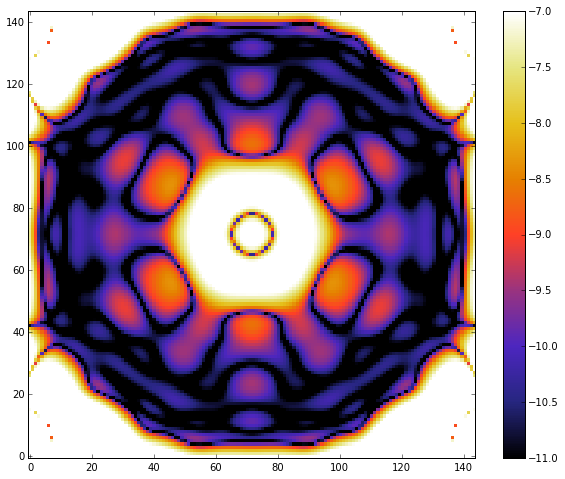

In [95]:
plt.figure(figsize=(10,8))
plt.imshow(np.log10(psf_img_polychrom[-1]), vmin=-11, vmax=-7, cmap='CMRmap')
plt.colorbar()

## Radial PSF profile

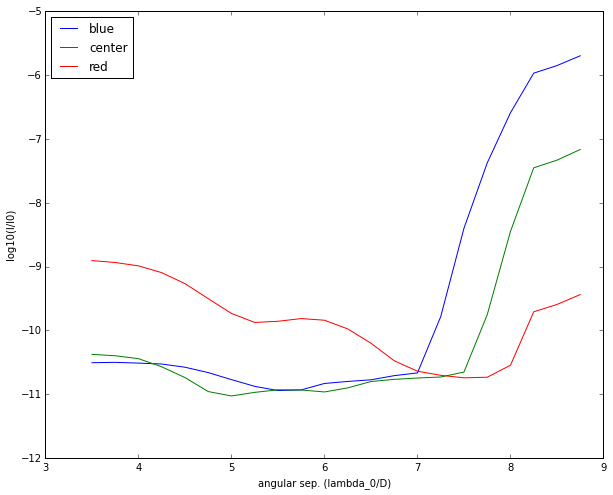

In [87]:
plt.figure(figsize=(10,8))
plt.plot(seps, np.log10(radial_psf_profile_polychrom[0,:]))
plt.plot(seps, np.log10(radial_psf_profile_polychrom[radial_psf_profile_polychrom.shape[0]/2,:]))
plt.plot(seps, np.log10(radial_psf_profile_polychrom[-1,:]))
plt.legend(['blue','center','red'], loc='upper left')
plt.xlabel('angular sep. (lambda_0/D)')
plt.ylabel('log10(I/I0)')

In [78]:
radial_psf_profile_polychrom[-1,0]

2.9158991890408384e-10